In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os
import cv2

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# join text and image data tables using product_id - this will be used to match up each image to its respective product_name and category

cleaned_text_data = pd.read_csv('cleaned_text_data.csv', index_col=0)
image_data = pd.read_csv('Images.csv', index_col=0)
joined_text_and_image_data = cleaned_text_data.join(image_data.set_index('product_id'), on='id', lsuffix='_left', rsuffix='_right')
list(joined_text_and_image_data.columns)
joined_text_and_image_data.rename({'id_left':'product_id', 'id_right':'image_id'}, axis=1, inplace=True)
joined_text_and_image_data.drop({'id','category2','category3','category4','category5','price','location','url','page_id','bucket_link','create_time'}, axis=1, inplace=True)
# joined_text_and_image_data.shape
joined_text_and_image_data.drop_duplicates(subset='product_id', keep='first', inplace=True)
# joined_text_and_image_data.head(15)
joined_text_and_image_data.reset_index(inplace=True)
new_df = joined_text_and_image_data.drop({'index','product_id','product_name','description','date_posted','image_ref'}, axis=1)
new_df.head()
# print(type(new_df))
# print(new_df['category1'].value_counts())

,category1,image_id
0,Home & Garden,64aa79f3-e9fa-417c-a332-714b8ce933f1
1,Home & Garden,4e670f9e-7feb-458f-b529-ac52547abe2b
2,Home & Garden,bfe77c38-c9eb-47fb-b3d6-31ffdefb6ff9
3,Home & Garden,698870d7-8bed-474a-879b-61d8338359fd
4,Home & Garden,244482c3-b882-4e3c-acfc-d59849257cbc


In [26]:
# assign a number to each category and create a column for the image arrays of each product

new_df['code'] = pd.factorize(new_df['category1'])[0] + 1
new_df = new_df[['category1','code','image_id']]
new_df['img_array'] = ''
randomised_new_df = new_df.sample(frac=1, random_state=1).reset_index(drop=True)
randomised_new_df.dropna(subset=['category1','code','image_id','img_array'], inplace=True)
randomised_new_df.head()

,category1,code,image_id,img_array
0,"Clothes, Footwear & Accessories",6,9c3c00e0-4dc8-4955-b052-537d17815700,
1,Office Furniture & Equipment,12,4e8ae668-f6c8-49f8-92d5-e4f8fd43f83e,
2,"Sports, Leisure & Travel",9,b7dddd1a-e053-406f-8afa-a159847d3e2e,
3,Video Games & Consoles,13,678df117-8dfa-4ccc-a54b-3dc8ac9ffe05,
4,Other Goods,7,624a76f3-1547-4dd5-9a80-5687038100a6,


In [27]:
# iterates over each product in table from cell 1 and uses its image_id to find the image in the local directory, before converting the image to an array and placing the array in the img_array column

path_to_images_cleaned_128x128 = "images_cleaned_128x128/"
for i in range(6228):
    x = randomised_new_df.iat[i,2]
    y = (f"128x128_cleaned_{x}")
    # print(y)
    img_array = mpimg.imread(f'{path_to_images_cleaned_128x128}{y}.jpg')
    # imgplot = plt.imshow(img_array)
    img_array_list = list(img_array)
    randomised_new_df.iat[i,3] = img_array
    i+=1
randomised_new_df.head(100)

,category1,code,image_id,img_array
0,"Clothes, Footwear & Accessories",6,9c3c00e0-4dc8-4955-b052-537d17815700,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,Office Furniture & Equipment,12,4e8ae668-f6c8-49f8-92d5-e4f8fd43f83e,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,"Sports, Leisure & Travel",9,b7dddd1a-e053-406f-8afa-a159847d3e2e,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,Video Games & Consoles,13,678df117-8dfa-4ccc-a54b-3dc8ac9ffe05,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,Other Goods,7,624a76f3-1547-4dd5-9a80-5687038100a6,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
...,...,...,...,...
97,Appliances,10,2655f0ff-439e-4106-8585-78f1e918a8f1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
98,Health & Beauty,8,e0e85c46-a290-4777-98f8-541598e02d2b,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
99,"Music, Films, Books & Games",4,1bc4f786-90f8-4b94-b3fd-b129be2c08f0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
100,DIY Tools & Materials,3,df850b3f-61ef-4f20-960e-241958b5430f,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [28]:
# one hot encodings

category_list = list(randomised_new_df['category1'].unique())
print(category_list)
category_list_as_numbers = pd.Series(list(category_list))
one_hot_encodings_dataframe = pd.get_dummies(randomised_new_df['category1'])
one_hot_encodings_dataframe

['Clothes, Footwear & Accessories ', 'Office Furniture & Equipment ', 'Sports, Leisure & Travel ', 'Video Games & Consoles ', 'Other Goods ', 'Phones, Mobile Phones & Telecoms ', 'Music, Films, Books & Games ', 'Baby & Kids Stuff ', 'Home & Garden ', 'Computers & Software ', 'Health & Beauty ', 'Appliances ', 'DIY Tools & Materials ']


,Appliances,Baby & Kids Stuff,"Clothes, Footwear & Accessories",Computers & Software,DIY Tools & Materials,Health & Beauty,Home & Garden,"Music, Films, Books & Games",Office Furniture & Equipment,Other Goods,"Phones, Mobile Phones & Telecoms","Sports, Leisure & Travel",Video Games & Consoles
0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6306,0,1,0,0,0,0,0,0,0,0,0,0,0
6307,0,0,0,0,0,1,0,0,0,0,0,0,0
6308,0,0,0,1,0,0,0,0,0,0,0,0,0
6309,0,0,0,0,0,0,1,0,0,0,0,0,0


In [34]:
# join two dataframes together

df_concat = pd.concat([randomised_new_df, one_hot_encodings_dataframe], axis=1)
df_concat.head(5)

,category1,code,image_id,img_array,Appliances,Baby & Kids Stuff,"Clothes, Footwear & Accessories",Computers & Software,DIY Tools & Materials,Health & Beauty,Home & Garden,"Music, Films, Books & Games",Office Furniture & Equipment,Other Goods,"Phones, Mobile Phones & Telecoms","Sports, Leisure & Travel",Video Games & Consoles
0,"Clothes, Footwear & Accessories",6,9c3c00e0-4dc8-4955-b052-537d17815700,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,0,1,0,0,0,0,0,0,0,0,0,0
1,Office Furniture & Equipment,12,4e8ae668-f6c8-49f8-92d5-e4f8fd43f83e,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,0,0,0,0,0,0,0,1,0,0,0,0
2,"Sports, Leisure & Travel",9,b7dddd1a-e053-406f-8afa-a159847d3e2e,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,0,0,0,0,0,0,0,0,0,0,1,0
3,Video Games & Consoles,13,678df117-8dfa-4ccc-a54b-3dc8ac9ffe05,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,0,0,0,0,0,0,0,0,0,0,0,1
4,Other Goods,7,624a76f3-1547-4dd5-9a80-5687038100a6,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,0,0,0,0,0,0,0,0,1,0,0,0


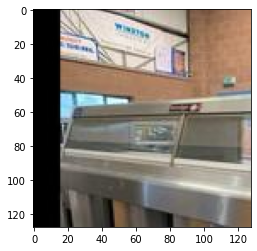

In [35]:
z = df_concat.iat[1,3]
imgplot = plt.imshow(z)


,category1,code,image_id,img_array,Appliances,Baby & Kids Stuff,"Clothes, Footwear & Accessories",Computers & Software,DIY Tools & Materials,Health & Beauty,Home & Garden,"Music, Films, Books & Games",Office Furniture & Equipment,Other Goods,"Phones, Mobile Phones & Telecoms","Sports, Leisure & Travel",Video Games & Consoles
0,"Clothes, Footwear & Accessories",6,9c3c00e0-4dc8-4955-b052-537d17815700,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,0,1,0,0,0,0,0,0,0,0,0,0
1,Office Furniture & Equipment,12,4e8ae668-f6c8-49f8-92d5-e4f8fd43f83e,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,0,0,0,0,0,0,0,1,0,0,0,0
2,"Sports, Leisure & Travel",9,b7dddd1a-e053-406f-8afa-a159847d3e2e,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,0,0,0,0,0,0,0,0,0,0,1,0
3,Video Games & Consoles,13,678df117-8dfa-4ccc-a54b-3dc8ac9ffe05,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,0,0,0,0,0,0,0,0,0,0,0,1
4,Other Goods,7,624a76f3-1547-4dd5-9a80-5687038100a6,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,0,0,0,0,0,0,0,0,1,0,0,0


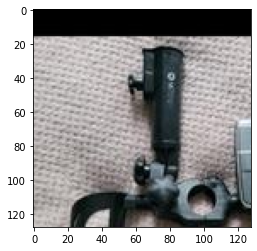

In [36]:
c = df_concat.iat[2,3]
imgplot = plt.imshow(c)
df_concat.head(5)


In [48]:
classification_model_df = df_concat.drop({'category1','image_id'}, axis=1)
classification_model_df.head(5)

,code,img_array,Appliances,Baby & Kids Stuff,"Clothes, Footwear & Accessories",Computers & Software,DIY Tools & Materials,Health & Beauty,Home & Garden,"Music, Films, Books & Games",Office Furniture & Equipment,Other Goods,"Phones, Mobile Phones & Telecoms","Sports, Leisure & Travel",Video Games & Consoles
0,6,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,0,1,0,0,0,0,0,0,0,0,0,0
1,12,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,0,0,0,0,0,0,0,1,0,0,0,0
2,9,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,0,0,0,0,0,0,0,0,0,0,1,0
3,13,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,0,0,0,0,0,0,0,0,0,0,0,1
4,7,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,0,0,0,0,0,0,0,0,1,0,0,0


In [49]:
classification_model_df.to_pickle("./classification_model_df.pkl")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os
import cv2

unpickled_df = pd.read_pickle("./classification_model_df.pkl")
unpickled_df.head(10)

,code,img_array,Appliances,Baby & Kids Stuff,"Clothes, Footwear & Accessories",Computers & Software,DIY Tools & Materials,Health & Beauty,Home & Garden,"Music, Films, Books & Games",Office Furniture & Equipment,Other Goods,"Phones, Mobile Phones & Telecoms","Sports, Leisure & Travel",Video Games & Consoles
0,6,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,0,1,0,0,0,0,0,0,0,0,0,0
1,12,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,0,0,0,0,0,0,0,1,0,0,0,0
2,9,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,0,0,0,0,0,0,0,0,0,0,1,0
3,13,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,0,0,0,0,0,0,0,0,0,0,0,1
4,7,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,0,0,0,0,0,0,0,0,1,0,0,0
5,5,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,0,0,0,0,0,0,0,0,0,1,0,0
7,12,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,0,0,0,0,0,0,0,1,0,0,0,0
8,13,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,0,0,0,0,0,0,0,0,0,0,0,1
9,9,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,0,0,0,0,0,0,0,0,0,0,1,0
10,4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,0,0,0,0,0,0,1,0,0,0,0,0


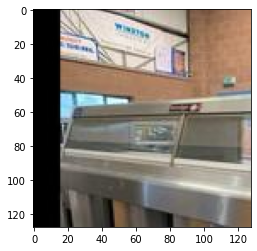

In [51]:
z1 = unpickled_df.iat[1,1]
imgplot = plt.imshow(z1)

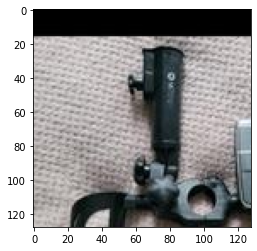

In [52]:
c1 = unpickled_df.iat[2,1]
imgplot = plt.imshow(c1)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os
import cv2

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# load pickle file into new dataframe
unpickled_df = pd.read_pickle("./classification_model_df.pkl")
unpickled_df['img_array'] = unpickled_df['img_array'].apply(lambda x: x.flatten())

# features
X = list(unpickled_df['img_array'])

# target
y = list(unpickled_df['code'])

# pipeline?

# parameters?

# split data in to train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# split test data into val/test
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

# instantiate and fit logistic regression
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

# predict
predictions = logistic_regression.predict(X_test)

# calculate accuracy score
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy Score: {accuracy}')

/home/mo/miniconda3/envs/project-4-env-01/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy Score: 0.11884368308351177
